In [1]:
import argparse
from collections import OrderedDict as odict
from functools import partial
from glob import glob
from joblib import Parallel, delayed
import json
import nibabel
from nipype.caching import Memory
from nipype.interfaces import fsl
from nilearn import datasets, image, plotting
from nilearn.input_data import NiftiMasker
from nilearn.regions import RegionExtractor
from nilearn.decomposition import CanICA
import numpy as np
import os
from os import makedirs, path
import pandas as pd
import pickle
import re
import shutil
import sys

from utils.secondlevel_utils import *
from utils.secondlevel_plot_utils import *

180822-00:57:05,560 duecredit ERROR:
	 Failed to import duecredit due to No module named 'duecredit'


### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 2ndlevel_analysis.ipynb

In [2]:
parser = argparse.ArgumentParser(description='fMRI Analysis Entrypoint Script.')
parser.add_argument('-derivatives_dir')
parser.add_argument('-working_dir', default=None)
parser.add_argument('--tasks', nargs="+")
parser.add_argument('--n_procs', default=4, type=int)
parser.add_argument('--num_perm', default=1000, type=int, help="Passed to fsl.randomize")
parser.add_argument('--ignore_rt', action='store_false')

if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.derivatives_dir='/data/derivatives'

In [3]:
derivatives_dir = args.derivatives_dir
fmriprep_dir = path.join(derivatives_dir, 'fmriprep', 'fmriprep')
first_level_dir = path.join(derivatives_dir, '1stlevel')
second_level_dir = path.join(derivatives_dir,'2ndlevel')
if args.working_dir is None:
    working_dir = path.join(derivatives_dir, '2ndlevel_workingdir')
else:
    working_dir = path.join(args.working_dir, '2ndlevel_workingdir')
makedirs(working_dir, exist_ok=True)
    
tasks = ['ANT', 'CCTHot', 'discountFix',
         'DPX', 'motorSelectiveStop',
         'stopSignal', 'stroop', 
         'surveyMedley', 'twoByTwo', 'WATT3']
if args.tasks:
    tasks = args.tasks
regress_rt = args.ignore_rt
model = 'model-rt' if regress_rt == True else 'model-nort'

### Create group Mask

In [4]:
def create_group_mask(mask_loc, fmriprep_dir, threshold=.8, verbose=True):
    if verbose:
        print('Creating Group mask...')
    makedirs(path.dirname(mask_loc), exist_ok=True)
    brainmasks = glob(path.join(fmriprep_dir,'sub-s???',
                               '*','func','*MNI152NLin2009cAsym_brainmask*'))
    mean_mask = image.mean_img(brainmasks)
    group_mask = image.math_img("a>=%s" % str(threshold), a=mean_mask)
    group_mask.to_filename(mask_loc)
    if verbose:
        print('Finished creating group mask')

In [5]:
# create mask over all tasks
# create 95% brain mask
mask_loc = path.join(second_level_dir, 'group_mask.nii.gz')
if path.exists(mask_loc) == False:
    create_group_mask(mask_loc, fmriprep_dir, .8)

### Create Group Maps

In [6]:
def get_contrast_names(subjectinfo_path):
    try:
        contrasts = pickle.load(open(subjectinfo_path, 'rb')).contrasts
        contrast_names = [i[0] for i in contrasts]
    except IndexError:
        print('No subjectinfo found for %s_%s' % (task, model))
        contrast_names = None
    return contrast_names

def save_smooth_maps(task, model=model, smoothness=4.4,
                     second_level_dir=second_level_dir,
                     first_level_dir=first_level_dir,
                     mask_loc=mask_loc,
                     verbose=True):
    task_dir = path.join(second_level_dir, task, model, 'wf-contrast')
    makedirs(task_dir, exist_ok=True)
    # get contrasts
    subjectinfo_paths = glob(path.join(first_level_dir, '*', task, model, 
                                       'wf-contrast','subjectinfo.pkl'))
    contrast_names = get_contrast_names(subjectinfo_paths[0])
    if contrast_names is None:
        return
    if verbose: print('Creating %s group map' % task)
    for i, contrast_name in enumerate(contrast_names):
        if verbose: print('    Contrast: %s' % contrast_name)
        # load, smooth, and concatenate contrasts
        map_files = sorted(
            glob( path.join(first_level_dir, '*', task, model,
                            '*contrast', '*cope%s.nii.gz' % str(i + 1))))
        # if there are map files, create group map
        if len(map_files) > 1:
            smooth_copes = concat_and_smooth(map_files, smoothness=smoothness)
            copes_concat = image.concat_imgs(
                smooth_copes.values(), auto_resample=True)
            copes_loc = path.join(task_dir, "%s_copes.nii.gz" % contrast_name)
            copes_concat.to_filename(copes_loc)
            
def save_tmaps(task, model=model,
               second_level_dir=second_level_dir,
               mask_loc=mask_loc):
    task_dir = path.join(second_level_dir, task, model, 'wf-contrast')
    contrasts = glob(path.join(task_dir, '*copes.nii.gz'))
    for copes_loc in contrasts:
        contrast_name = path.basename(copes_loc).split('_copes')[0]
        # perform permutation test to assess significance
        mem = Memory(base_dir=working_dir)
        randomise = mem.cache(fsl.Randomise)
        randomise_results = randomise(
            in_file=copes_loc,
            mask=mask_loc,
            one_sample_group_mean=True,
            tfce=True,  # look at paper
            vox_p_values=True,
            num_perm=args.num_perm)
        # save results
        tfile_loc = path.join(task_dir, "%s_raw_tfile.nii" % contrast_name)
        tfile_corrected_loc = path.join(task_dir,
                                   "%s_corrected_tfile.nii" % contrast_name)
        raw_tfile = randomise_results.outputs.tstat_files[0]
        corrected_tfile = randomise_results.outputs.t_corrected_p_files[0]
        shutil.move(raw_tfile, tfile_loc)
        shutil.move(corrected_tfile, tfile_corrected_loc)

In [ ]:
# create partial function to pass to parallel
# smooth
contrast_smooth_parallel = partial(save_smooth_maps, model=model, smoothness=4.4, 
                                    second_level_dir=second_level_dir,
                                    first_level_dir=first_level_dir,
                                    mask_loc=mask_loc,
                                    verbose=False)
Parallel(n_jobs=args.n_procs)(delayed(contrast_smooth_parallel)(task) for task in tasks)
# then tmap
contrast_tmap_parallel = partial(save_tmaps, model=model, 
                                    second_level_dir=second_level_dir,
                                    mask_loc=mask_loc)
Parallel(n_jobs=args.n_procs)(delayed(contrast_tmap_parallel)(task) for task in tasks)

In [124]:
# % matplotlib inline
# task_contrasts = glob(path.join(second_level_dir, '*', 'model-rt', 'wf-contrast'))
# plot_2ndlevel_maps(task_contrasts[0], lookup='*raw*')
# plot_2ndlevel_maps(task_contrasts[1], lookup='*corrected*', threshold=.95)

### Use Parcellation to Project 1st-level Maps into low dimensional space

Projecting into a lower dimensional space allows the evaluation of whole-brain similarity analysis (clustering)

In [6]:
# set up functions with some default parameters
a = partial(get_map_files, first_level_dir=first_level_dir,
                       tasks=tasks, model=model)
b = partial(get_ICA_parcellation, mask_loc=mask_loc, working_dir=working_dir)

#### Get parcellations to use

In [8]:
map_files = get_map_files(map_prefix='zstat')
ICA_parcel = get_ICA_parcellation(map_files, n_comps=20, file_name='contrast')

target_img = list(map_files.values())[0] # get image to resample atlases to
harvard_parcel, harvard_labels = get_established_parcellation("Harvard_Oxford", target_img=target_img)
smith_parcel, smith_labels = get_established_parcellation("smith", target_img=target_img)

[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[Memory]    0.0s, 0.0min: Loading randomized_svd from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/utils/extmath/randomized_svd/07b7a742605b773b292a7a1fbe1664e0
______________________________________randomized_svd cache loaded - 0.4s, 0.0min
[Memory]    2.3s, 0.0min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/511947ca2d81661030825d6bcfff59be
_____________________________________________fastica cache loaded - 0.8s, 0.0min
[Memory]    3.2s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/e06d08f31511fbb6734e9b36645cc1bd


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.8s, 0.0min
[Memory]    4.1s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/5aba2629185d90e86675701e2f6f96b5


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.4s, 0.0min
[Memory]    4.6s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/8772ca00ddc3b9a317436415e2316568
_____________________________________________fastica cache loaded - 0.1s, 0.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


[Memory]    4.8s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/541191c45b6c49ac4316196321a7e34f
_____________________________________________fastica cache loaded - 0.3s, 0.0min
[Memory]    5.2s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/8b2e76c73225e226ca3bf72c021c587f


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.5s, 0.0min
[Memory]    5.8s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/28886604021422452976c9ef89e992a8


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.5s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.7s, 0.0min
[Memory]    6.6s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/921b08c1d1fa657252895425b7a95a87


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.3s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.3s, 0.0min
[Memory]    7.0s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/bd0d35cbc66659fdee62d4059c4bdc8f
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]    7.1s, 0.1min: Loading fastica from /data/derivatives/2ndlevel_workingdir/nilearn_cache/joblib/sklearn/decomposition/fastica_/fastica/9847f25ad7fc5567f5b87e5d719015c0


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.8s remaining:    0.0s


_____________________________________________fastica cache loaded - 0.0s, 0.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished
/usr/local/miniconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


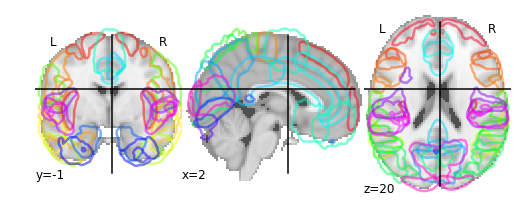

In [13]:
# %matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")
# plotting.plot_prob_atlas(harvard_parcel)
# # what is RegionExtractor?

#### Use parcellation to create ROIs and calculate RDMs amongst contrasts within each ROI

Set up hyper parameters

In [100]:
parcel = harvard_parcel
labels = harvard_labels
threshold = 10

In [101]:
roi_contrasts = extract_roi_vals(map_files, parcel, threshold, labels=labels) 
RDMs = get_RDMs(roi_contrasts)

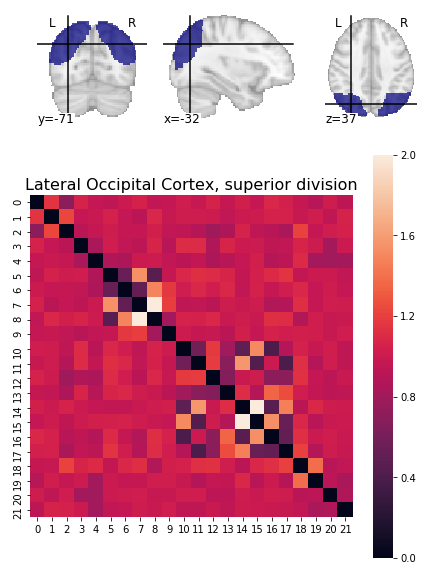

In [110]:
# plot random RDM
label = np.random.choice(list(RDMs.keys()))
index = labels.index(label)
roi = get_ROI_from_parcel(parcel, index, threshold)
plot_RDM(RDMs[label], roi, title=label)

#### RDM of RDMs

Each ROI has an RDM reflecting its "representation" of cognitive faculties probed by these contrasts. We can look at the similarity of RDMs to get a sense of the similarity of the cognitive fingerprint of individual regions

In [114]:
# similarity of RDMs
keys = list(RDMs.keys())
vectorized_RDMs = np.vstack([RDMs[k].flatten() for k in keys])
RDM_of_RDMs = 1-np.corrcoef(vectorized_RDMs)
RDM_of_RDMs = pd.DataFrame(RDM_of_RDMs, index=keys, columns=keys)

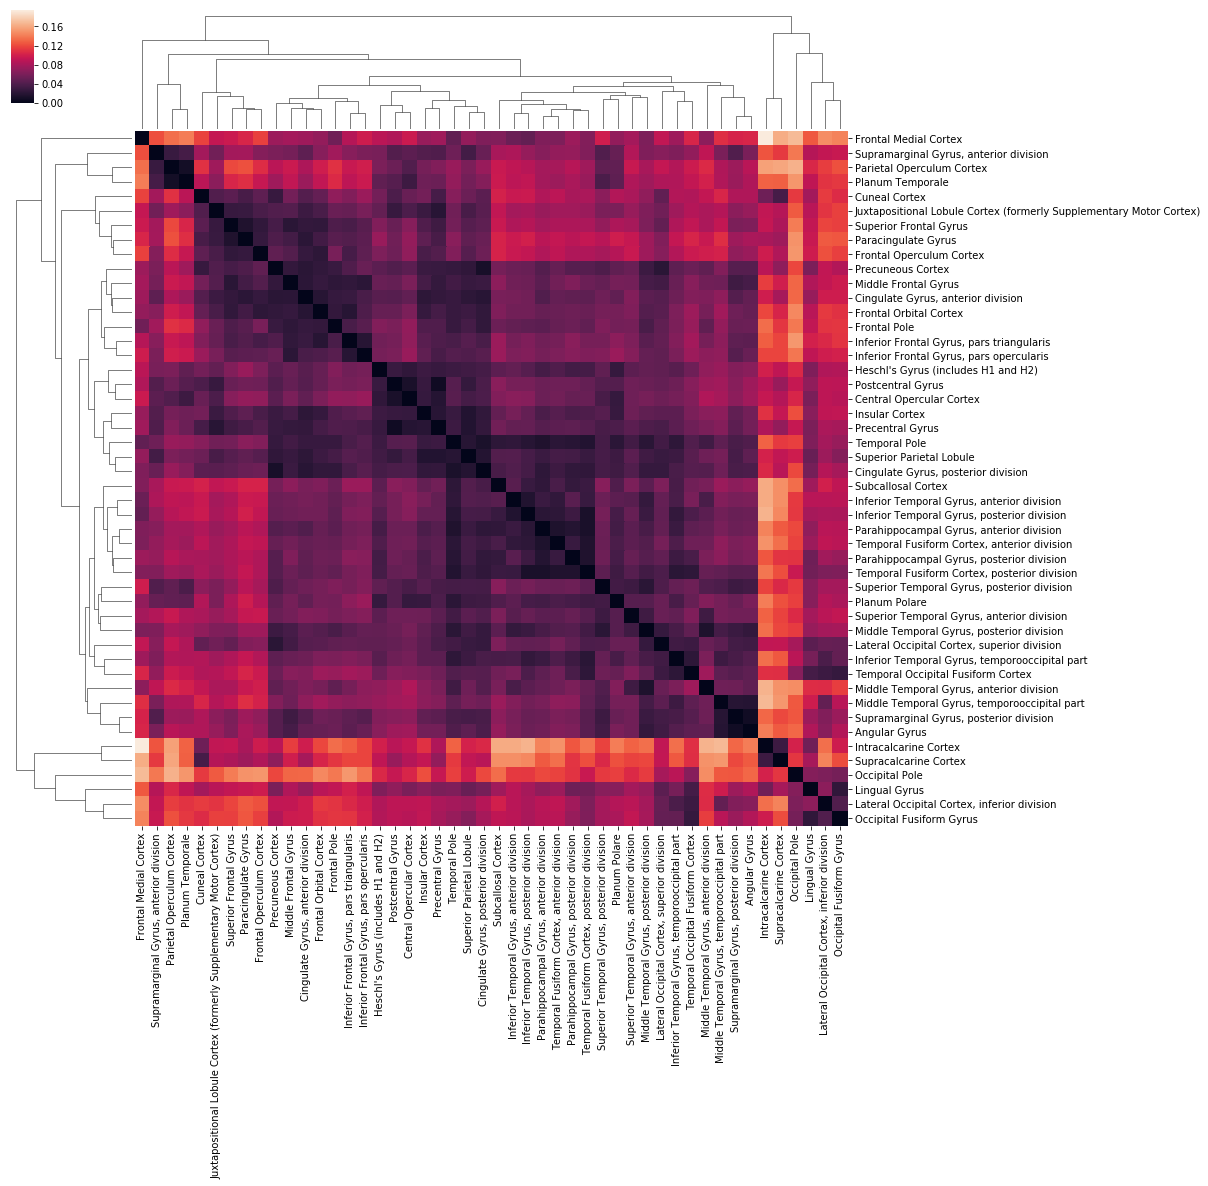

In [115]:
# visualize RDM of RDMs
sns.clustermap(RDM_of_RDMs, figsize=[15,15])

#### Apply parcellations

In [ ]:
"""
# ********************************************************
# Set up parcellation
# ********************************************************

#******************* Estimate parcellation from data ***********************
print('Creating ICA based parcellation')


# group map files by subject
subject_ids = np.unique([f.split(os.sep)[-2].split('_')[0] for f in map_files])
subject_map_files = []
for s in subject_ids:
    subject_map_files.append(image.concat_imgs([f for f in map_files if s in f]))






# ********************************************************
# Reduce dimensionality of contrasts
# ********************************************************
def split_index(projections_df):
    subj = [f.split('_')[0] for f in projections_df.index]
    contrast = ['_'.join(f.split('_')[1:]) for f in projections_df.index]
    projections_df.insert(0, 'subj', subj)
    projections_df.insert(1, 'contrast', contrast)
    
    
parcellation_files = [('smith70', smith_networks),
                      ('canica20', 
                       join(output_dir, 'canica20_explicit_contrasts.nii.gz')),
                      ('canica50', 
                       join(output_dir, 'canica50_explicit_contrasts.nii.gz')),
                       ('canica70', 
                       join(output_dir, 'canica70_explicit_contrasts.nii.gz'))
                       ]

for parcellation_name, parcellation_file in parcellation_files:
    projection_filey = join(output_dir, '%s_projection.json' % parcellation_name)
    mask_file = join(output_dir, 'group_mask.nii.gz')
    projections_df = create_projections_df(parcellation_file, mask_file, 
                                           data_dir, tasks, projection_filey)
    
    # create a subject x neural feature vector where each column is a component
    # for one contrast
    neural_feature_mat = create_neural_feature_mat(projections_df,
                                                   filename=join(output_dir, 
                                                        '%s_neural_features.json'  
                                                        % parcellation_name))
"""